In [2]:
from bs4 import BeautifulSoup
import bs4 as bs
import urllib.request
import pandas as pd
import numpy as np
import re
import requests
from lxml import html
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


Start with webscraping all of the New York Time recipe pages that are referenced in the Kaggle Dataset. The data that we are interested in is the recipe ratings and the number of ingredients that each recipe requires.

In [3]:
first_third=pd.read_csv('first_third_of_data.csv')
second_third=pd.read_csv('second_third_of_data.csv')
last_third=pd.read_csv('last_third_of_data.csv')

/Users/Eva/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pd.concat(first_third, second_third,last_third)

/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_35810/2203416143.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat(first_third, second_third,last_third)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [6]:
data=pd.read_csv('nyt_recipe_comments_Jun25.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

/Users/Eva/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
data.head()

,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,commentTitle,...,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,recipe_id,recipe_name
0,20158342.0,approved,20158342.0,1570140.0,Christa,<br/>,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,20158342.0,False,1015646,shredded oxtail salad with mustard and shallot
1,110917145.0,approved,110917145.0,87444971.0,Lindsey,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,110917145.0,False,1012940,aunt gens biscotti
2,104240855.0,approved,104240855.0,68602151.0,VFR Marc,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,104240855.0,False,1012940,aunt gens biscotti
3,16837960.0,approved,16837960.0,30298351.0,Joanne,<br/>,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,16837960.0,False,1017810,turkey dinner canapes
4,111016114.0,approved,111016114.0,57140404.0,Rachel,NaN,NaN,NaN,NaN,<br\//>,...,NaN,NaN,1.0,comment,0.0,0.0,111016114.0,False,1019207,lalla mussa dal


In [11]:
def create_urls(end, urls):
    base_url='https://cooking.nytimes.com/recipes/'+end
    urls.append(base_url)

In [56]:
end_url=[]

group_df=data.groupby(['recipe_id','recipe_name']).sum()
group_df=pd.DataFrame(group_df)
group_df=group_df.reset_index()


id_dict={}

for row in range(len(group_df)):
    recipe_id=str(group_df.loc[row,'recipe_id'])
    id_dict[recipe_id]=[]
    recipe_name=group_df.loc[row,'recipe_name']
    recipe_name=recipe_name.replace(" ","-")
    end_url.append(recipe_id+'-'+recipe_name)
    
urls=[]    
for end in end_url:
    create_urls(end, urls)

In [57]:
len(id_dict)

8436

In [61]:
def scrape_recipe_page(main_url):
    soup = BeautifulSoup(requests.get(main_url).text, "html.parser")
    
    #Scrape recipe rating
    try:
        rating_text=soup.find("script", type="application/ld+json").text
        begin_pos=rating_text.find("ratingValue")
        rating_text=rating_text[begin_pos:]
        end_pos=rating_text.find(":")
        rating=rating_text[end_pos+1:end_pos+2]
    except:
        rating=-1

    #Scrape the number of ingredients
    num_ingredients=len(soup.find_all("span", class_="ingredient-name"))
    
    #Add back to dict to later join with dataframe
    pos_num=re.search(r"\d", main_url)
    if pos_num:
        end_num=main_url[pos_num.start():].find('-')
        if len(id_dict[main_url[pos_num.start():pos_num.start()+end_num]])<2:
            id_dict[main_url[pos_num.start():pos_num.start()+end_num]].extend([num_ingredients,rating])
        else:
            pass   

In [ ]:
for url in urls:
    scrape_recipe_page(url)

In [60]:
id_dict

{'852': [10, '4'],
 '1466': [14, '4'],
 '1467': [10, '4'],
 '1468': [12, '4'],
 '1469': [6, '4'],
 '1470': [7, '5'],
 '1473': [7, '4'],
 '1475': [6, '4'],
 '1746': [6, '4'],
 '1801': [6, '4'],
 '3783': [8, '5'],
 '4406': [13, '5'],
 '4599': [6, '5'],
 '5294': [7, '4'],
 '5612': [11, '4'],
 '5613': [10, '5'],
 '6970': [6, '4'],
 '8665': [8, '5'],
 '9558': [12, '5'],
 '11206': [13, '4'],
 '11376': [4, '5'],
 '11404': [15, '4'],
 '12141': [4, '5'],
 '12142': [15, '5'],
 '12144': [8, '4'],
 '12145': [17, '5'],
 '12146': [9, '5'],
 '12148': [11, '5'],
 '12151': [8, '4'],
 '12152': [6, '5'],
 '12153': [11, '3'],
 '12154': [10, '4'],
 '12155': [10, '4'],
 '12156': [8, '4'],
 '12157': [7, '4'],
 '12158': [19, '5'],
 '12159': [19, '5'],
 '12160': [2, '3'],
 '12166': [7, '4'],
 '12168': [9, '5'],
 '12169': [18, '5'],
 '12170': [13, '4'],
 '12173': [17, '4'],
 '12176': [9, '4'],
 '12177': [14, '5'],
 '12178': [12, '4'],
 '12179': [12, '4'],
 '12180': [9, '5'],
 '12181': [10, '4'],
 '12182': [9, '

In [ ]:
ingredient_rating_df=pd.DataFrame.from_dict(id_dict, orient='index',
                       columns=['num_ingredients', 'rating'])

ingredient_rating_df.index.name='recipe_id'      
ingredient_rating_df

In [8]:
ingredient_rating_df.to_csv('ingredient_rating_df.csv')

NameError: name 'ingredient_rating_df' is not defined

--------- start running here if csv is already downloaded ---------

In [9]:
ratings=pd.read_csv('ingredient_rating_df.csv')
ratings

,recipe_id,num_ingredients,rating
0,852,10,4
1,1466,14,4
2,1467,10,4
3,1468,12,4
4,1469,6,4
...,...,...,...
8431,1022327,13,4
8432,1022328,6,4
8433,1022332,19,4
8434,1022345,6,4


In [50]:
#recipes that do not have ratings are represented with a -1, how should we deal with this? Maybe just drop those columns

In [10]:
len(np.unique(data['recipe_id']))

8436

In [11]:
len(ratings['recipe_id'])

8436

In [12]:
data=data.join(ratings.set_index('recipe_id'), on='recipe_id', how='left')

Now we are going to use the dataset to try and develop a model that can predict a recipe's rating.
Some things that we will look at are:
- number of ingredients that a recipe requires
- the average sentiment of the comments left per recipe (can add a column to our dataset that has the average sentiment value of the comments left on a 
- the number of replies? 
- can also create a model and then run feature importance
- do we want to add calories and other nutritional information to the dataframe?
- regression model 
    - random forest regression 
- exploratory data analysis:
    - distributions of comments (how often are there no or many comments), sentiment analysis, ratings (usually bimodal)
    - word clouds
    
- may want to run data on only 40% of original data

In [38]:
neg=[]
pos=[]
neu=[]

overall_sentiment=[]

positive_count=0
neutral_count=0
negative_count=0

sia = SentimentIntensityAnalyzer()

for comment in range(len(data)):
    scores_dict=sia.polarity_scores(data.loc[comment,'commentBody'])
    neg_score=scores_dict['neg']
    neu_score=scores_dict['neu']
    pos_score=scores_dict['pos']
    
    if max([neg_score,neu_score,pos_score]) == neg_score:
        negative_count+=1
        overall_sentiment.append('negative')
    elif max([neg_score,neu_score,pos_score]) == neu_score:
        neutral_count+=1
        overall_sentiment.append('neutral')
    elif max([neg_score,neu_score,pos_score]) == pos_score:
        positive_count+=1
        overall_sentiment.append('positive')
            
    neg.append(neg_score)
    neu.append(neu_score)
    pos.append(pos_score)

data['negative']=neg
data['positive']=pos
data['neutral']=neu

/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_34093/606091201.py:16: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


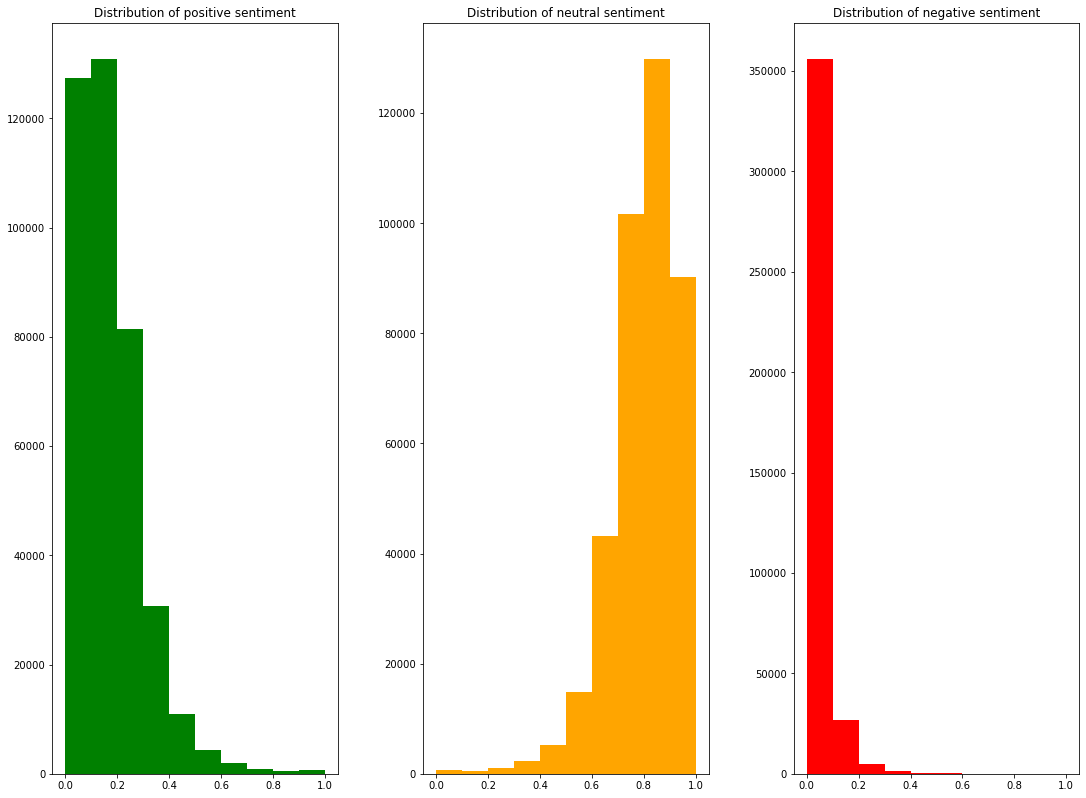

In [39]:
figure(figsize=(16, 12))


plt.subplot(1, 3, 1) # row column count
plt.hist(data['positive'], color='green')
plt.title('Distribution of positive sentiment')

plt.subplot(1, 3, 2) # row column count
plt.hist(data['neutral'], color='orange')
plt.title('Distribution of neutral sentiment')

plt.subplot(1, 3, 3) # row column count
plt.hist(data['negative'], color='red')
plt.title('Distribution of negative sentiment')

plt.tight_layout(4)

We can observe that most comments have a positive sentiment of around 0.0-0.3, neutral sentiment of around 0.6-1.0, and negative sentiment of 0.0-0.2.

Based on the distribution of negative sentiments, it seems like people's comments aren't usually overtly negative. Instead comments are pretty neutral. 

Since all comments have a score for positive, neutral, and negative, maybe we should look at a comment's three scores, pick the largest score and count that comment as either positive, neutral, or negative? 

In [40]:
data['overall_sentiment']=overall_sentiment

In [42]:
print(positive_count)
print(neutral_count)
print(negative_count)

8656
380945
362


Huge majority of comments are neutral? Kinda strange.

Next, visualize ratings and overall sentiment.

In [99]:
positive_com=data[data['overall_sentiment']=='positive']
positive_com=positive_com.reset_index()
negative_com=data[data['overall_sentiment']=='negative']
negative_com=negative_com.reset_index()

/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_34093/2180435008.py:12: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


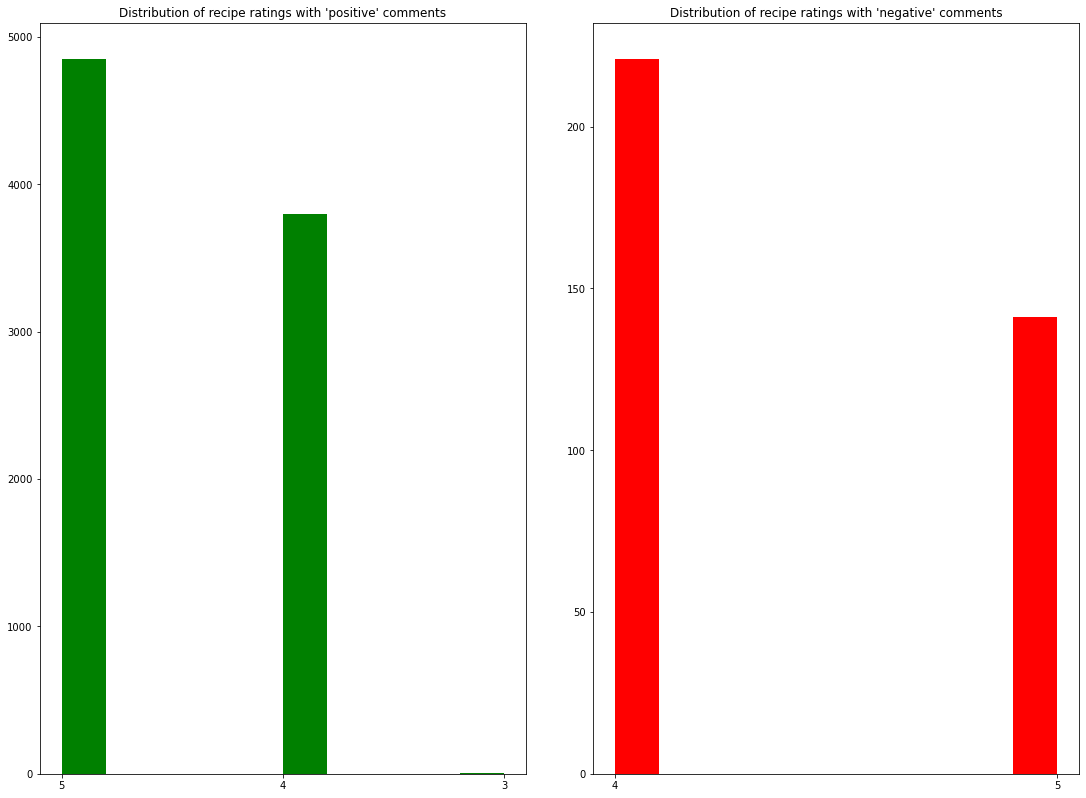

In [67]:
figure(figsize=(16, 12))

plt.subplot(1, 2, 1) # row column count
plt.hist(positive_com['rating'], color='green')
plt.title("Distribution of recipe ratings with 'positive' comments")

plt.subplot(1, 2, 2) # row column count
plt.hist(negative_com['rating'], color='red')
plt.title("Distribution of recipe ratings with 'negative' comments")


plt.tight_layout(4)

Interestingly, comments that were labelled "negative" based on sentiment analysis only had ratings of 4-5. 

(array([2.98000e+02, 0.00000e+00, 2.06281e+05, 0.00000e+00, 0.00000e+00,
        1.83333e+05, 0.00000e+00, 4.60000e+01, 0.00000e+00, 5.00000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

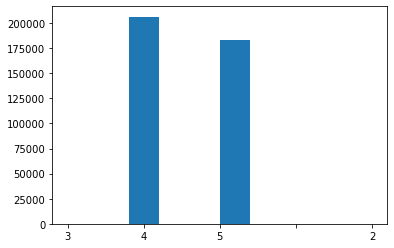

In [68]:
plt.hist(data['rating'])

In [98]:
positive_com

,index,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,...,permID,isAnonymous,recipe_id,recipe_name,num_ingredients,rating,negative,positive,neutral,overall_sentiment
0,97,108545089.0,approved,108545089.0,139723462.0,Katie,NaN,NaN,NaN,NaN,...,108545089.0,False,1017931,pizza dough,4,5,0.000,0.555,0.445,positive
1,99,108137474.0,approved,108137474.0,89254845.0,V. Mon,NaN,NaN,NaN,NaN,...,108137474.0,False,1017931,pizza dough,4,5,0.000,0.827,0.173,positive
2,116,106952404.0,approved,106952404.0,58480670.0,Nickie Lisella,NaN,NaN,NaN,NaN,...,106952404.0,False,1017931,pizza dough,4,5,0.000,0.724,0.276,positive
3,121,106716645.0,approved,106716645.0,71034371.0,Md45,NaN,NaN,NaN,NaN,...,106716645.0,False,1017931,pizza dough,4,5,0.000,0.688,0.312,positive
4,155,27755844.0,approved,27755844.0,86317979.0,Suzanne,<br/>,NaN,NaN,NaN,...,27755844.0,False,1017931,pizza dough,4,5,0.000,0.666,0.334,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,389525,111020690.0,approved,111020690.0,117389414.0,Nathan M.,NaN,NaN,NaN,NaN,...,111020690.0,False,1021040,vegan fettuccine alfredo,13,4,0.000,0.555,0.445,positive
8652,389593,30366086.0,approved,30366086.0,73110280.0,linda,<br/>,NaN,NaN,NaN,...,30366086.0,False,1019854,cacio e pepe frico,3,4,0.000,0.649,0.351,positive
8653,389635,30504557.0,approved,30504557.0,550607.0,Robin,<br/>,NaN,NaN,NaN,...,30504557.0,False,1019910,sumac scented eggplant and chickpeas,13,4,0.000,0.512,0.488,positive
8654,389707,25538852.0,approved,25538852.0,6365760.0,Laura,<br/>,NaN,NaN,NaN,...,25538852.0,False,1016200,laurie colwins baked mustard chicken,9,5,0.174,0.433,0.393,positive


Text(0.5, 1.0, 'Negative Comments')

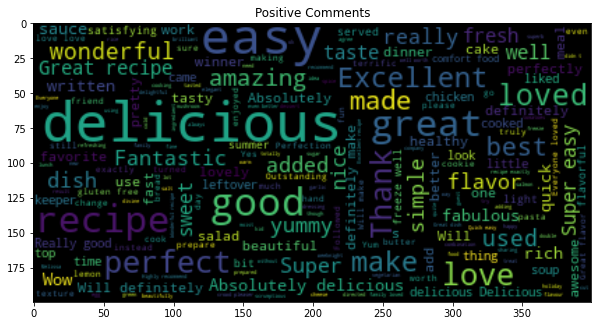

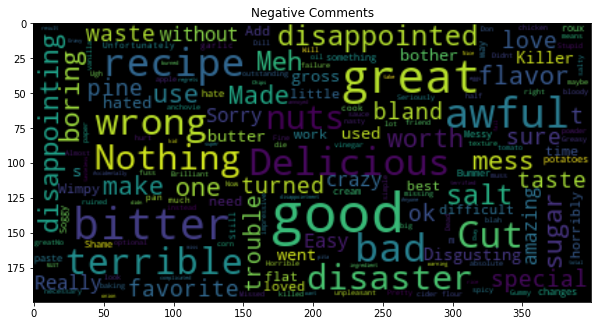

In [101]:
from wordcloud import WordCloud

positive_str=''
for row in range(len(positive_com)):
    positive_str=positive_str+positive_com.loc[row,'commentBody']

negative_str=''
for row in range(len(negative_com)):
    negative_str=negative_str+negative_com.loc[row,'commentBody']


wc = WordCloud(max_font_size=40).generate(positive_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear") 
plt.title("Positive Comments")

wc = WordCloud(max_font_size=40).generate(negative_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Comments")

Compare word clouds based on sentiment with word clouds based on ratings:

In [110]:
data=data[data['rating']!=' ']

In [112]:
data["rating"] = pd.to_numeric(data["rating"])

/var/folders/d4/p5txydrd2bbdjmss4gy6zmy80000gp/T/ipykernel_34093/3696035011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rating"] = pd.to_numeric(data["rating"])


In [116]:
above_4=data[data['rating']>=4]
above_4=above_4.reset_index()
below_3=data[data['rating']<=3]
below_3=below_3.reset_index()

Text(0.5, 1.0, 'Comments for recipes that received a rating of 3 or below')

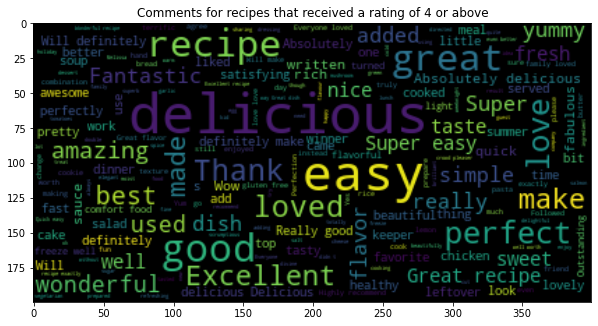

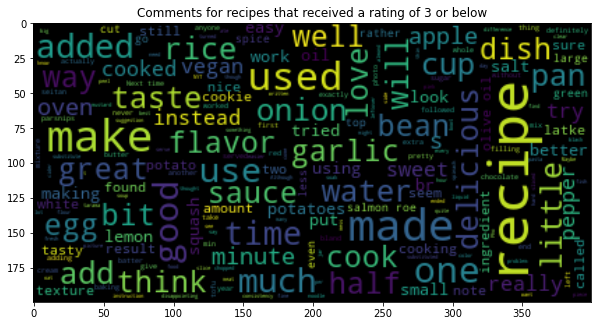

In [117]:
above4_str=''
for row in range(len(above_4)):
    above4_str=positive_str+above_4.loc[row,'commentBody']

below3_str=''
for row in range(len(below_3)):
    below3_str=below3_str+below_3.loc[row,'commentBody']

wc = WordCloud(max_font_size=40).generate(above4_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear") 
plt.title("Comments for recipes that received a rating of 4 or above")

wc = WordCloud(max_font_size=40).generate(below3_str)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.title("Comments for recipes that received a rating of 3 or below")